# Stock Market Predictions with LSTM

Discover Long Short-Term Memory (LSTM) networks in Python and how you can use them to make stock market predictions!

In this tutorial, you will see how you can use a time-series model known as Long Short-Term Memory (LSTM) models. LSTM models are powerful, especially retaining long-term memory, by their design as you will see later. You'll tackle the following topics in this tutorial:

- Understand why should you need to be able to predict stock prices / movements
- Download the data - You will be using stock market data gathered from Yahoo finance
- Split train-test data and data normalization
- See few averaging techniques that can be used for one-step ahead predictions
- Motivate and briefly discuss an LSTM model as it allows to predict more than one-step ahead
- Predict and visualize future stock market with current data

If you're not familiar with deep learning or neural networks, you should take a look at a Deep Learning in Python course. It should covers the basics, as well as how to build a neural network on your own in Keras. Keras is now part of TensorFlow 2.0, which will be used in this tutorial, but the idea is the same.

## Why Do You Need Time Series Models?

You would like to model this stock prices correctly, so as a stock buyer you can reasonably decide when to buy stocks and when to sell them to gain profit. This is where time series modelling comes in. You need good machine learning models that can look at the history of a sequence of data and correctly predict the future elements of the sequence are going to be.

__Warning__: Stock market prices are highly unpredictable and volatile. This means that there are no consistent patterns in the data that allows us to model stock prices over time near-perfectly. Don't take it from me, take it from Princeton University economist Burton Malkiel, who argues in his 1973 book, "A Random Walk Down Wall Street," that if the market is truly efficient and a share price reflects all factors immediately as soon as they're made public, a blindfolded monkey throwing darts at a newspaper stock listing should do as well as any investment professional.

However, let's not go all the way believing that this is just a stochastic / random process and no hope for machine learning. Let's see if you can at least model the data, so that the predictions you make correlate with the actual behavior of the data. In other words, you don't need the exact stock values of the future, but the stock price movements (that is, if it is going to rise of fall in the near future).

In [1]:
# Make sure that you have all these libaries available to run the code successfully
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json 
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler

## Downloading the Data

You will be using data from the following sources:
Alpha Vantage. Before you start, however, you will first need an API key, which you can obtain for free here. After that, you can assign that key to the api_key variable.
Use the data from this page. You will need to copy the Stocks folder in the zip file to your project home folder.
Stock prices come in several different flavours. They are,
Open: Opening stock price of the day
Close: Closing stock price of the day
High: Highest stock price of the data
Low: Lowest stock price of the day
Getting Data from Alphavantage

You will first load in the data from Alpha Vantage. Since you're going to make use of the American Airlines Stock market prices to make your predictions, you set the ticker to "AAL". Additionally, you also define a url_string, which will return a JSON file with all the stock market data for American Airlines within the last 20 years, and a file_to_save, which will be the file to which you save the data. You'll use the ticker variable that you defined beforehand to help name this file.
Next, you're going to specify a condition: if you haven't already saved data, you will go ahead and grab the data from the URL that you set in url_string; You'll store the date, low, high, volume, close, open values to a pandas DataFrame df and you'll save it to file_to_save. However, if the data is already there, you'll just load it from the CSV.
Getting Data from Kaggle

Data found on Kaggle is a collection of csv files and you don't have to do any preprocessing, so you can directly load the data into a Pandas DataFrame.

data_source = 'alphavantage' # alphavantage or kaggle

if data_source == 'alphavantage':
    # ====================== Loading Data from Alpha Vantage ==================================

    api_key = 'R2RWIKKGHM8JQ0W2'

    # American Airlines stock market prices
    ticker = "AAL"

    # JSON file with all the stock market data for AAL from the last 20 years
    url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

    # Save data to this file
    file_to_save = 'stock_market_data-%s.csv'%ticker

    # If you haven't already saved data,
    # Go ahead and grab the data from the url
    # And store date, low, high, volume, close, open values to a Pandas DataFrame
    if not os.path.exists(file_to_save):
        with urllib.request.urlopen(url_string) as url:
            data = json.loads(url.read().decode())
            # extract stock market data
            data = data['Time Series (Daily)']
            df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
            for k,v in data.items():
                date = dt.datetime.strptime(k, '%Y-%m-%d')
                data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                            float(v['4. close']),float(v['1. open'])]
                df.loc[-1,:] = data_row
                df.index = df.index + 1
        print('Data saved to : %s'%file_to_save)        
        df.to_csv(file_to_save)

    # If the data is already there, just load it from the CSV
    else:
        print('File already exists. Loading data from CSV')
        df = pd.read_csv(file_to_save)

else:

    # ====================== Loading Data from Kaggle ==================================
    # You will be using HP's data. Feel free to experiment with other data.
    # But while doing so, be careful to have a large enough dataset and also pay attention to the data normalization
    df = pd.read_csv(os.path.join('Stocks','hpq.us.txt'),delimiter=',',usecols=['Date','Open','High','Low','Close'])
    print('Loaded data from the Kaggle repository')

## Data Exploration

Here you will print the data you collected in to the DataFrame. You should also make sure that the data is sorted by date, because the order of the data is crucial in time series modelling.


In [6]:
# Sort DataFrame by date
df = df.sort_values('Date')

# Double check the result
df.head()

,Unnamed: 0,Date,Low,High,Close,Open
3536,0,2005-09-27,19.10,21.40,19.30,21.05
3535,1,2005-09-28,19.20,20.53,20.50,19.30
3534,2,2005-09-29,20.10,20.58,20.21,20.40
3533,3,2005-09-30,20.18,21.05,21.01,20.26
3532,4,2005-10-03,20.90,21.75,21.50,20.90


## Data Visualization

Now let's see what sort of data you have. You want data with various patterns occurring over time.

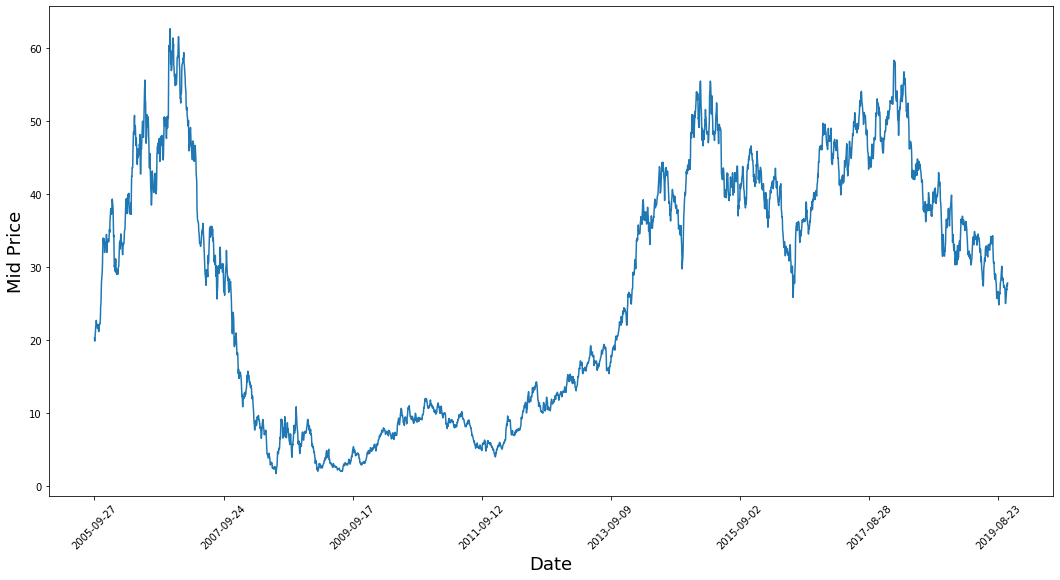

In [7]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

This graph already says a lot of things. The specific reason I picked this company over others is that this graph is bursting with different behaviors of stock prices over time. This will make the learning more robust as well as give you a change to test how good the predictions are for a variety of situations.

Another thing to notice is that the values close to 2017 are much higher and fluctuate more than the values close to the 1970s. Therefore you need to make sure that the data behaves in similar value ranges throughout the time frame. You will take care of this during the data normalization phase.

## Splitting Data into a Training set and a Test set

You will use the mid price calculated by taking the average of the highest and lowest recorded prices on a day.

In [8]:
# First calculate the mid prices from the highest and lowest
high_prices = df.loc[:,'High'].as_matrix()
low_prices = df.loc[:,'Low'].as_matrix()
mid_prices = (high_prices+low_prices)/2.0

/Users/bochmann/lib/anaconda3/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Users/bochmann/lib/anaconda3/envs/tf2/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Now you can split the training data and test data. The training data will be the first 11,000 data points of the time series and rest will be test data.

In [21]:
train_data = mid_prices[:2500]
test_data = mid_prices[2500:]

## Normalizing the Data

Now you need to define a scaler to normalize the data. `MinMaxScalar` scales all the data to be in the region of 0 and 1. You can also reshape the training and test data to be in the shape `[data_size, num_features]`.

In [22]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

Due to the observation you made earlier, that is, different time periods of data have different value ranges, you normalize the data by splitting the full series into windows. If you don't do this, the earlier data will be close to 0 and will not add much value to the learning process. Here you choose a window size of 2500.

__Tip__: when choosing the window size make sure it's not too small, because when you perform windowed-normalization, it can introduce a break at the very end of each window, as each window is normalized independently.

In this example, 4 data points will be affected by this. But given you have 11,000 data points, 4 points will not cause any issue

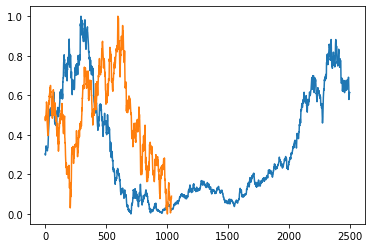

In [25]:
plt.plot (train_data)
plt.plot (test_data)

In [28]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 100
for di in range(0,2500,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by MinMaxScaler.